# Signal processing
Here, we'll explore a few useful tools for dealing with time series data, particularly EEG and ECoG data.

### By the end of this notebook, you'll be able to:
* Demonstrate how we can add sine waves to create complex waveforms
* Apply a fourier transform to your data
* Filter data by frequency bandwidths of interest
* Use Welch's method to create a power spectral density plot

First, let's get set up:

In [1]:
%config InlineBackend.figure_format = 'retina' # Improve the resolution of our plots!
%matplotlib inline

# All of the lovely packages we need for today
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

## Part I: Simple sine waves

Let's first generate a sine wave. We'll then generate a second sine wave and add these together to understand what a fourier transform of this data would look like. **Sine waves** are defined by their frequency, ampltitude, and and phase.

In [12]:
f = 1024 # Sampling frequency
dur = 10 # 10 seconds of signal
freq = 7 # 7 Hz signal
freq2 = 130 # 130 Hz signal

t = np.arange(0, dur, 1/f) # Generate a time vector

sig1 = np.sin(2 * np.pi * freq * t) # Generate a sine wave
sig1 = 2 * sig1; # Increase the power of signal 1

sig2 = np.sin(2 * np.pi * freq2 * t) # Generate another sine wave

In [4]:
f = 1024 # Sampling frequency
dur = 10 # 10 seconds of signal
t = np.arange(0, dur, 1/f) # Generate a time vector
t.max()

9.9990234375

Plot our sine waves.

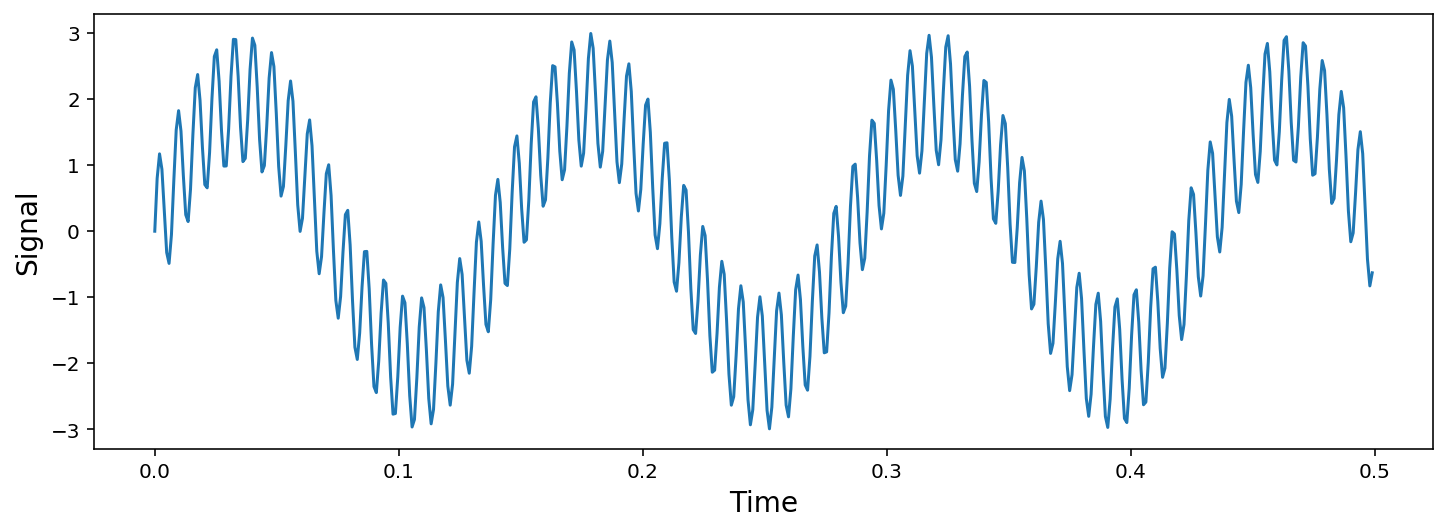

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(t[0:512],sig1[0:512]+sig2[0:512]) #plot 0.5 seconds of data
plt.ylabel('Signal',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.show()

Below, we'll calculate the **Fourier Transform** using the fast fourier transform package from numpy. The fft (developed by Tukey -- same Tukey as the statistics Tukey -- in 1965) implements a _discrete_ Fourier transform for a digital signal.

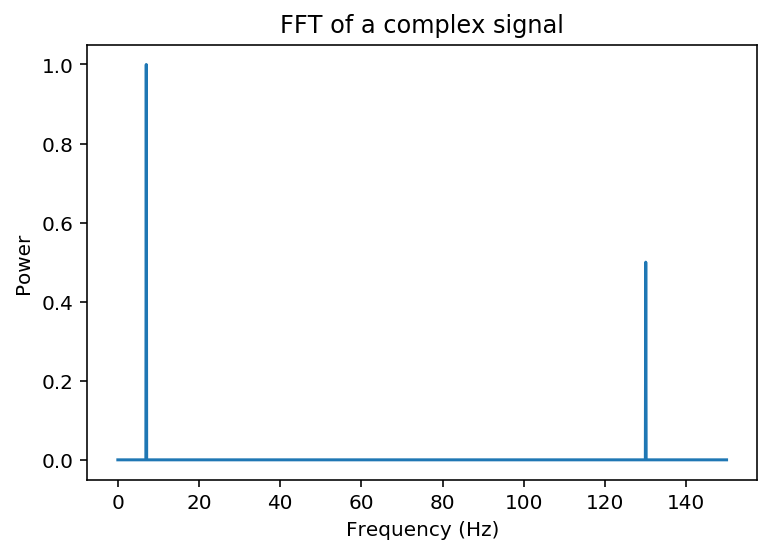

In [16]:
# Calculate the fourier transform of complex signal
fourier = np.fft.fft(sig1+sig2)/len(t) # Compute the fft, normalized by time

# Find frequency values for the x axis
nyq = f/2 # Determine the nyquist frequency

# Create freq bins for plotting by creating a vector from 0 to nyquist
# with as many points as in fft
fx_bins = np.linspace(0,nyq,np.floor(len(sig1)/2)+1)

# Plotting up to 200 Hz
plt.plot(fx_bins[0:1500],abs(fourier[0:1500])) # Plot a select range of frequencies
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of a complex signal')
plt.show()

**Note**: As Pascal Wallisch & Eric Nylen have written: "Frequency space is a place of _magic and wonder_." The Fourier transform of a time series usually involves complex numbers with imaginary parts. If we plot the Fourier transform itself by typing `plt.plot(fourier)`, it will yield a funky plot. That’s because the complex numbers represent both magnitude and phase at once, but we are _only interested in amplitude or power_ at this point, which is why we plotted only the absolute values above. Also, if you type `plt.plot(abs(fourier))`, you will get a plot of all the magnitudes, but note that it is mirror-symmetric in the middle—it repeats after half the sampling rate, which is why we plotted things only up to half the sampling rate above.

Before we move on, let's tackle one more issue: **Nyquist frequency**. Recall from lecture that signals can only be represented properly if one is sampling the signal more than twice as fast as the fastest frequency component in the signal itself. Otherwise, our sampled signal will be distorted. Below, we'll plot a set of graphs with different sampling frequencies to demonstrate this point.

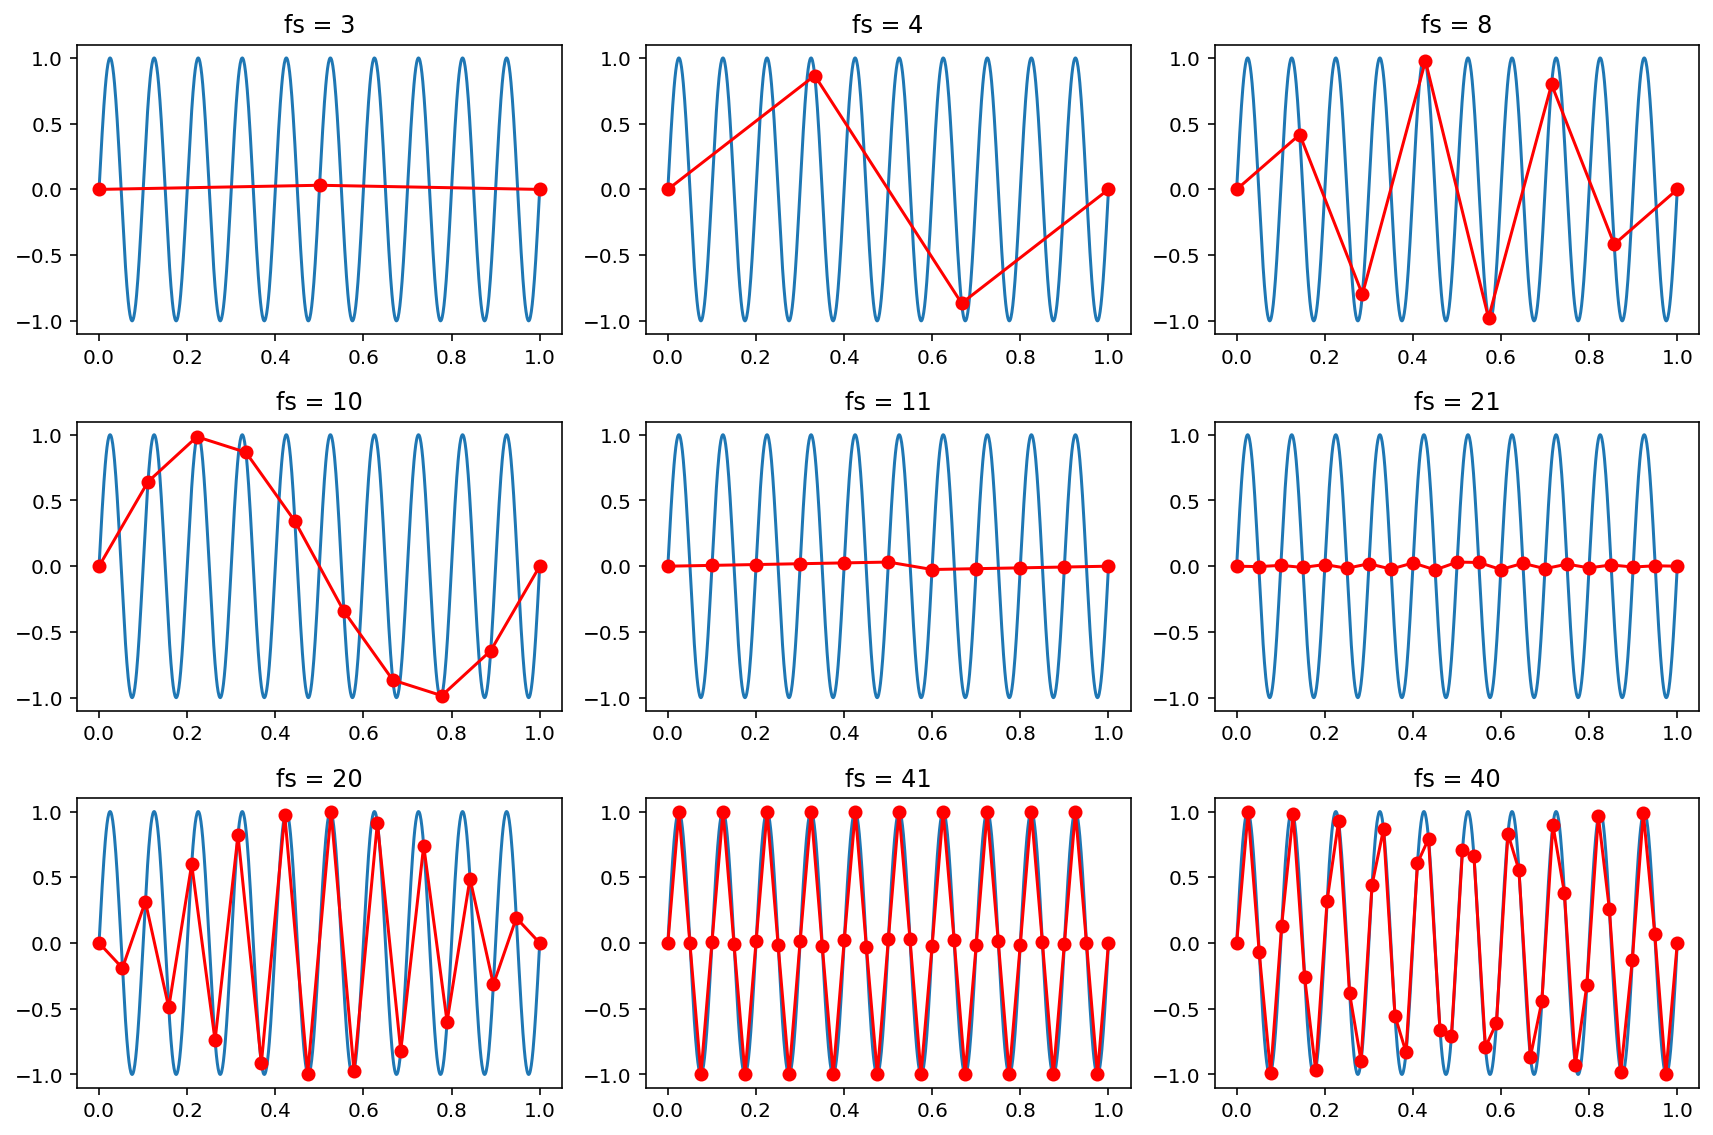

In [15]:
realSampling = 1000 # Define the real frequency
t = np.linspace(0,1,realSampling) # Define a time base with the same resolution
signalFrequency = 10 # Define the signal frequency
sampling_freq_list = [3, 4, 8, 10, 11, 21, 20, 41, 40] # Define nine different sampling rates
sig = np.sin(2*np.pi*signalFrequency*t)# Define a sine wave at our signal frequency

# Plot these graphs
fig, ax = plt.subplots(figsize=(12, 8))

for ii,sampleRate in enumerate(sampling_freq_list):
    ax = plt.subplot(3,3,ii+1) # Change the subplot (best way with a grid)
    ax.plot(t,sig) #  Plot the "real" signal over time
    sampledSignal = np.rint(np.linspace(0, len(t)-1, sampleRate)).astype(int) # Calculate the sampled signal
    
    # Plot sampled signal over the same time base, but in red
    q = ax.plot(t[sampledSignal],sig[sampledSignal],c='r',marker='o',markersize=6); 
    plt.tight_layout() # Fix the layout
    plt.title('fs = '+str(sampleRate)) 

Notice that at the nyquest frequency (20 hz), we can recover at least the number of cycles in the original signal, even if we haven't captured their amplitude. We have to go to _more than_ twice the Nyquist frequency (here 41) in order to capture the amplitude of our data. Going beyond these leads to diminishing returns.

## Step 2. Import and filter real sleep data.

Normal physiological data is never as regular as the data above -- it's usually chock full of lots of different waves, as well as noise. Now that we have a sense of the tools we need, let's work with some real data.

The data we'll import here is a real 30-seconds extract of slow-wave sleep from a young individual, collected by the Walker Lab at UC Berkeley. This data was collected at 100 Hz from channel 'F3'. This sampling frequency is fine for EEG data, but wouldn't be enough for high frequency spiking data. That kind of data is typically sampled at 40 **k**Hz.

In [16]:
import urllib.request

# URL of data to download
data_url = 'https://raphaelvallat.com/images/tutorials/bandpower/data.txt'

# Get the data and save it locally as "sleep_data.txt"
sleep_data, headers = urllib.request.urlretrieve(data_url, './sleep_data.txt')

In [18]:
# Load the .txt file as a numpy array
data = np.loadtxt('sleep_data.txt')

First, we'll plot the raw data. The data provides the information about voltage for the y axis. However, we need to also create a time vector, so that we can accurately label the x axis. The `np.arange()` method is very useful for this. We need to create a vector that is the same length as our data, but where each number is in terms of **time**, not **samples**. To do so, we'll divide our vector by the sampling rate.

<div class="alert alert-success">

**Task**: Plot the data below. Create a `time_vector` variable so that your data is plotted in seconds, not samples.

</div>

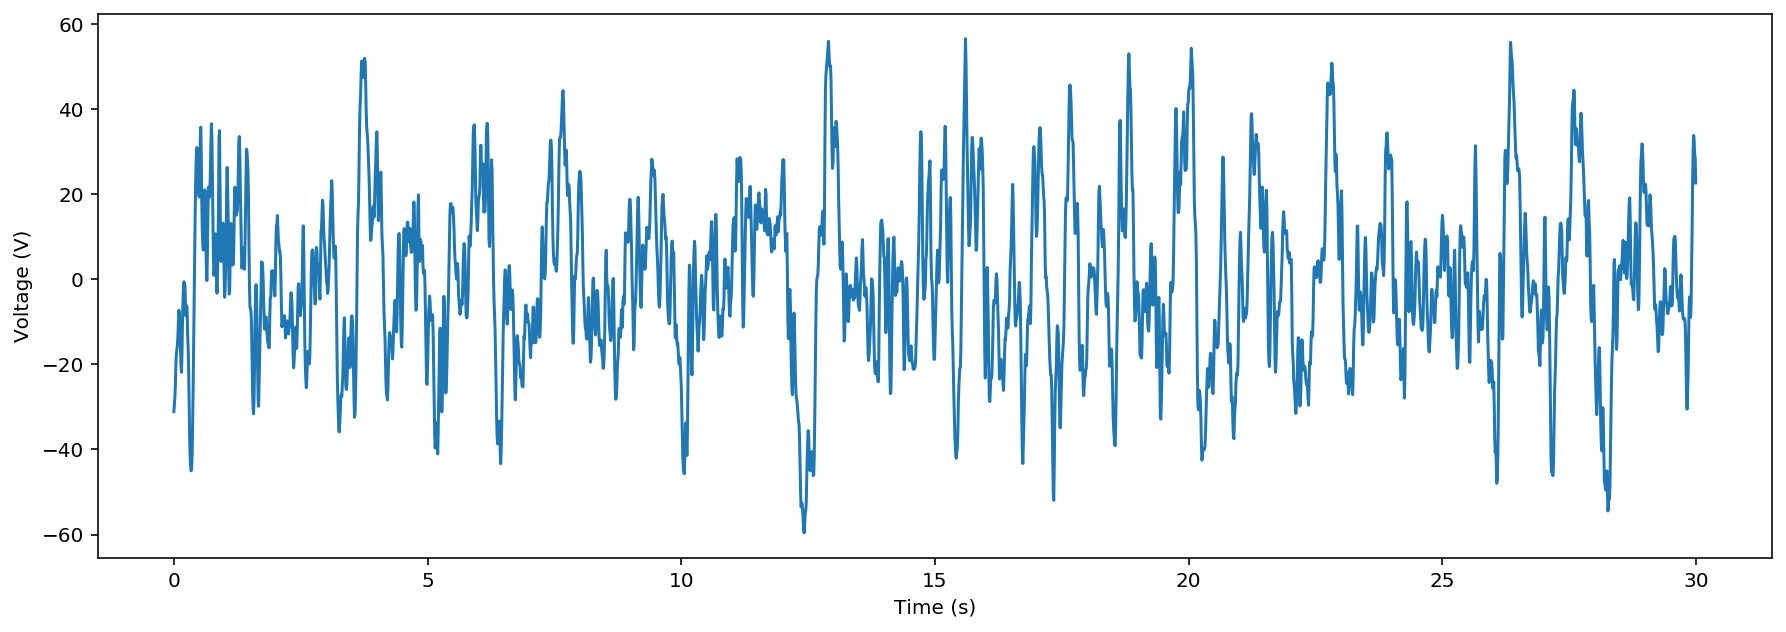

In [26]:
sampling_freq = 100

time_vector = np.arange(0,30,1/sampling_freq)
fig = plt.figure(figsize=(15,5))
plt.plot(time_vector,data)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()

## Apply a bandpass filter to our signal

Below, we'll compute a bandpass by first applying a _low-pass filter_, followed by a _high-pass filter_ (or vice versa).

Signal filtration is usually accomplished in 2 steps
1. Design a _filter kernel_
2. Apply the filter kernel to the data
    
We will use a **Butterworth** filter. The ideal filter would _completely_ pass everything in the passband (i.e., allow through the parts of the signal we care about) and completely reject everything outside of it, but this cannot be achieved in reality—the Butterworth filter is a close approximation.

We design the filter in Python using `scipy`'s `signal.butter` function, with three arguments:
1. The _filter order_ (we'll use a 4th order filter)
2. The _filter frequency_ (we must adjust for the sampling frequency, `f_s`, which is 100 Hz for these data, i.e. 100 data points were recorded per second)
3. The type of filter (`'lowpass'` or `'highpass'`)

It returns 2 filter parameters, `a` and `b`. Then, the bandpass filter is applied using `signal.filtfilt`, which takes as its parameters `b`, `a`, and the signal to be processed

Below, an example bandpass computation is shown to extract the _alpha_ rhythm from the channel 1 data, the results are stored in a dictionary called `oscillations_filtered`, with the oscillation name (e.g. `'alpha'`) as the key

In [28]:
# Define lower and upper limits of our bandpass
filter_limits = [0.5, 4]

# First, apply a lowpass filter
b, a = signal.butter(4, (filter_limits[1]/ (sampling_freq / 2)), 'lowpass') # Design filter with high filter limit
lowpassed = signal.filtfilt(b, a, data) # Apply it forwards and backwards (filtfilt)

# Then, apply a high pass filter
b, a = signal.butter(4, (filter_limits[0] / (sampling_freq / 2)), 'highpass') # Design filter with low filter limit
bandpassed = signal.filtfilt(b, a, lowpassed) # Apply it

/opt/conda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Now, let's plot our original and bandpassed data.

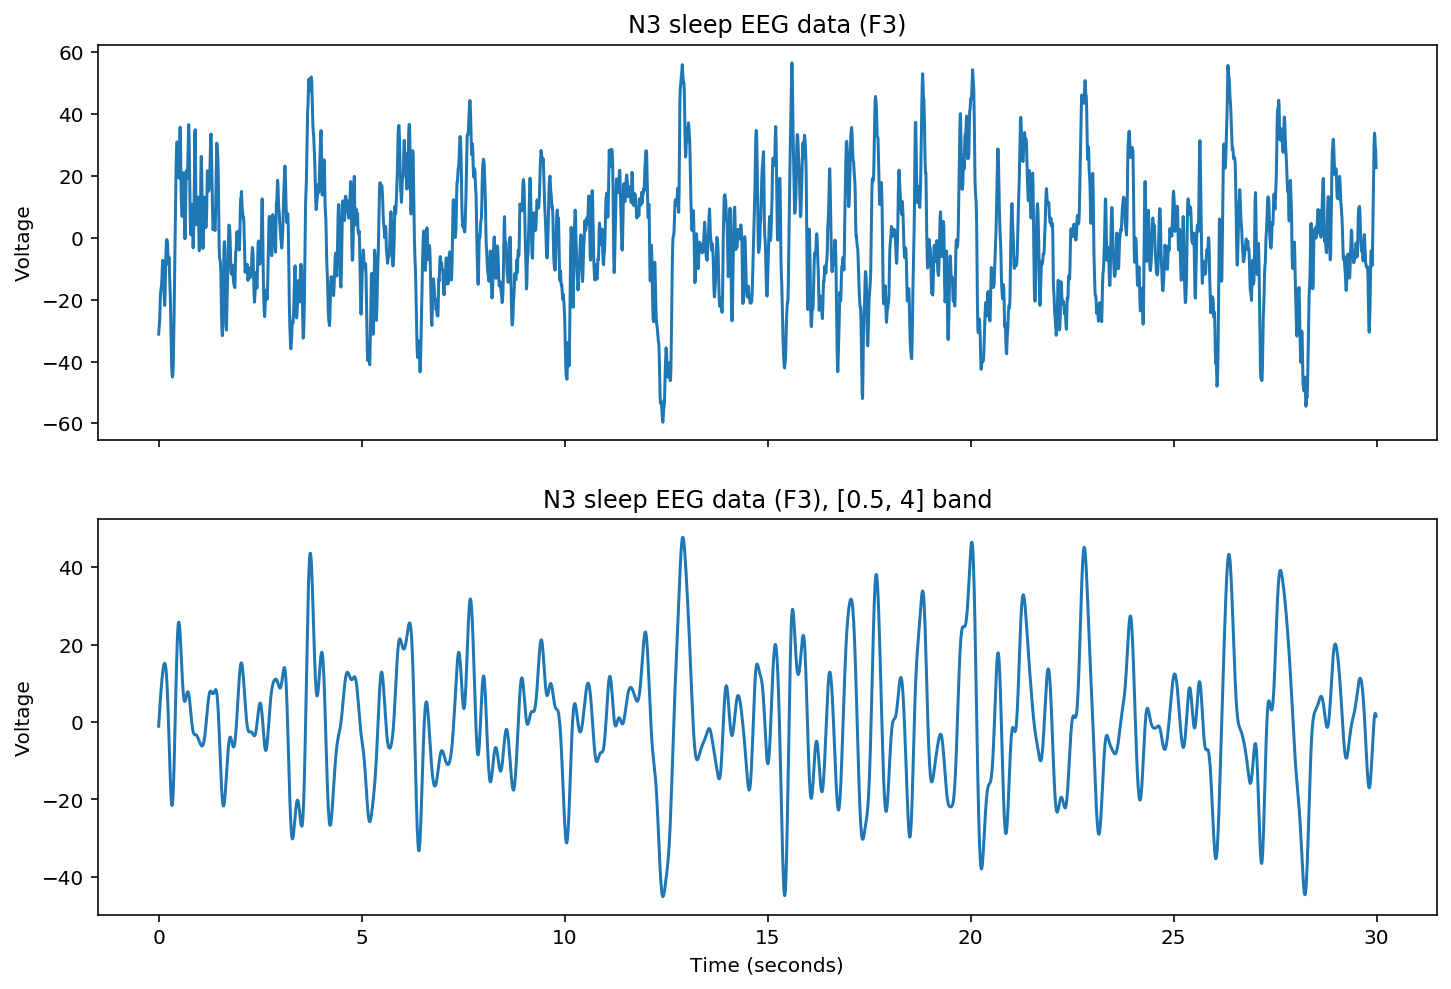

In [29]:
fig, ax = plt.subplots(2,1,figsize=(12, 8), sharex=True)

# Plot our raw data
ax[0].plot(time_vector,data)
ax[0].set_ylabel('Voltage')
ax[0].set_title('N3 sleep EEG data (F3)')

# Plot the bandpassed data
ax[1].plot(time_vector,bandpassed)
ax[1].set_ylabel('Voltage')

# Let's programmatically set the title here, using {} format
ax[1].set_title('N3 sleep EEG data (F3), {} band' .format(filter_limits))

plt.xlabel('Time (seconds)')
plt.show()

This filtering is useful for cleaning up the data, but what if we still want a _quantitative_ idea of our the strength of our signal in these different frequency bands? This is where our fourier transform comes in handy. In order to compute the average bandpower in the delta band, we first need to compute an estimate of the **power spectral density** (PSD).

<div class="alert alert-success">

**Task**: Compute the fourier transform of `data` and plot it as a PSD plot. You only need to plot frequencies from 0 to 50 Hz, which is from `0:1500` in your `fx_bins`. Plot the same `0:1500` slice of your `fourier` vector as well. 

</div>

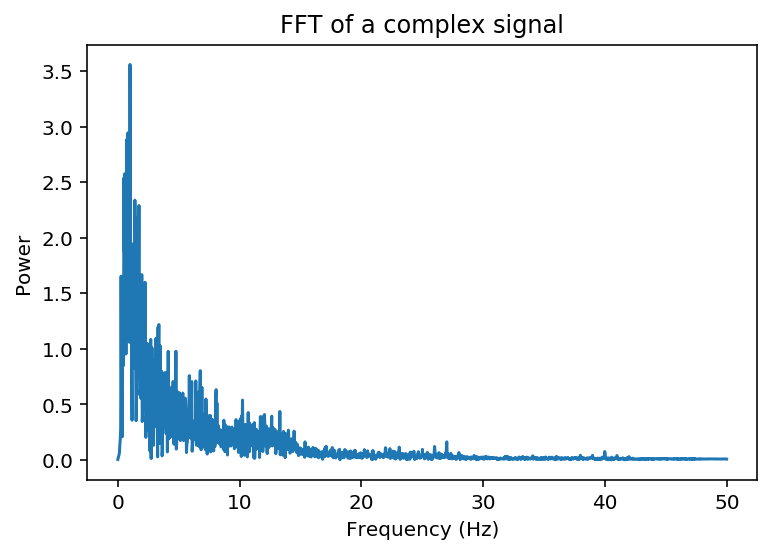

In [30]:
# Calculate the fourier transform of complex signal
fourier = np.fft.fft(data)/len(time_vector) # Compute the fft, normalized by time

# Find frequency values for the x axis
nyq = sampling_freq/2 # Determine the nyquist frequency

# Create freq bins for plotting by creating a vector from 0 to nyquist
# with as many points as in fft
fx_bins = np.linspace(0,nyq,np.floor(len(data)/2)+1)

# Plotting up to 200 Hz
plt.plot(fx_bins[0:1500],abs(fourier[0:1500])) # Plot a select range of frequencies
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of a complex signal')
plt.show()

Hmm, this is interesting but a bit noisy. Maybe we need a method that is _better_ than the fourier transform for this type of data. Thankfully, there's a way to smooth out our fft without losing too much information. 

The most widely-used method to do that is [**Welch's Method**](https://en.wikipedia.org/wiki/Welch%27s_method), which consists in averaging consecutive Fourier transform of small windows of the signal, with or without overlapping. Basically, we calculate the fft of a signal across a few sliding windows, and then calculate the mean PSD from all the sliding windows.

The `freqs` vector contains the x-axis (frequency bins) and the `psd` vector contains the y-axis (power spectral density). The units of the power spectral density, when working with EEG data, is usually $\mu$V^2 per Hz.

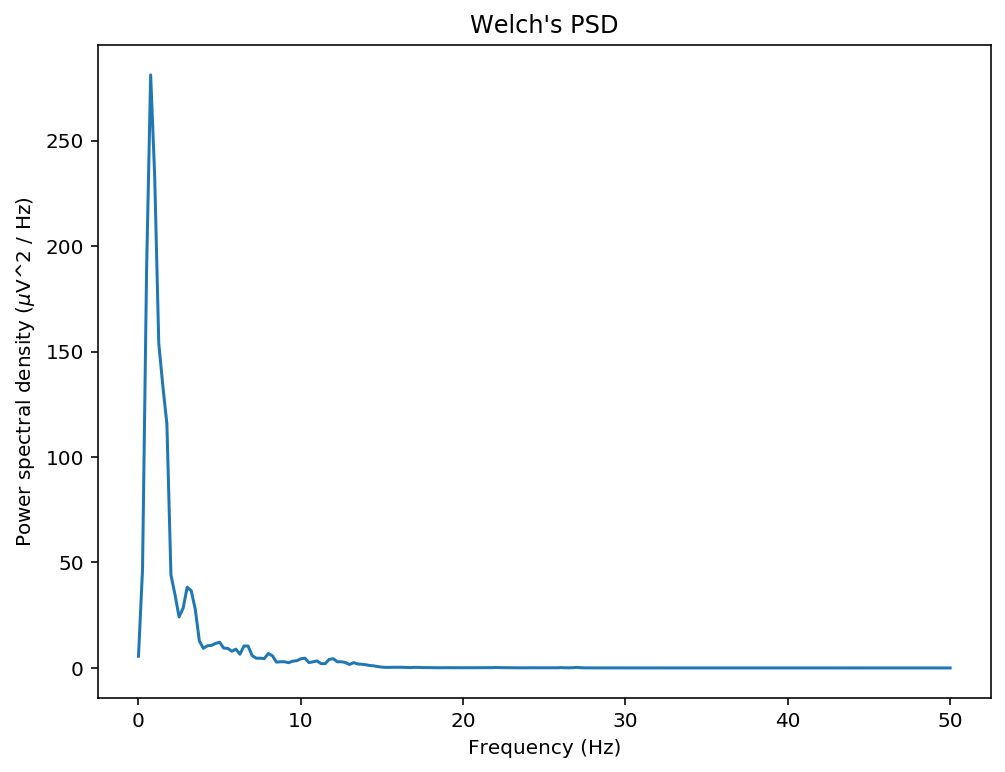

In [22]:
# Define sliding window length (4 seconds, which will give us 2 full cycles at 0.5 Hz)
win = 4 * sampling_freq
freqs, psd = signal.welch(data, sampling_freq, nperseg=win)

# Plot the power spectrum
plt.figure(figsize=(8, 6))
plt.plot(freqs, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.title("Welch's PSD")
plt.show()

That's much easier to interpret! And more importantly, it's computationally sound.

**Note**: Sometimes you'll see these plots in log-log, where both the x and y axes are scaled in log10 units. You can do so with the `plt.loglog()` plotting method (instead of `plt.plot()`).

Lastly, we can zoom into the part of the plot we're interested in -- the delta power.

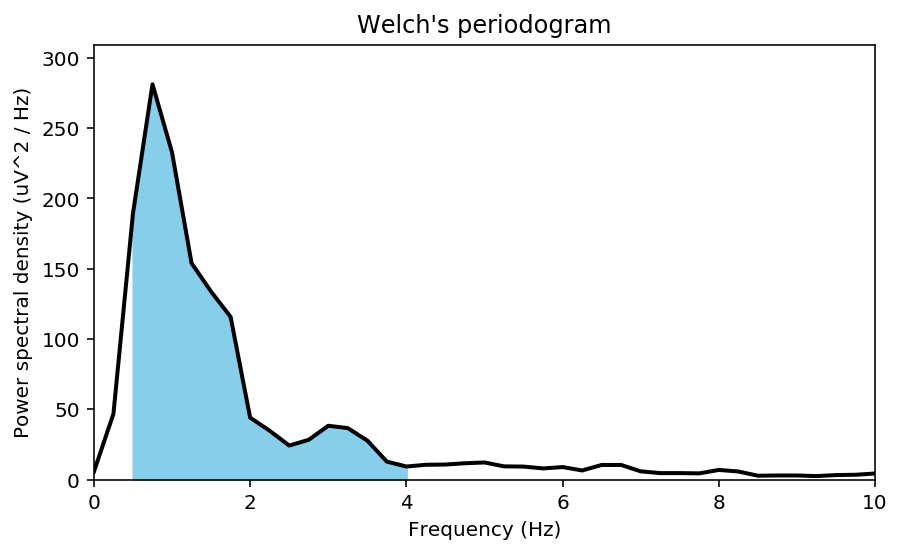

In [23]:
delta = [0.5,4]

# Find intersecting delta values in frequency vector
idx_delta = np.logical_and(freqs >= delta[0], freqs <= delta[1])

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.show()

As a final demonstration, we can plot a spectrogram of our signal. This is a common way to visualize EEG signals. The spectrogram results from doing the FFT on the snippet of the signal that falls into a “window,” plotting the frequency content in the window, then moving the window in time and plotting the frequency content again (and again) until the window has moved across the entire signal.

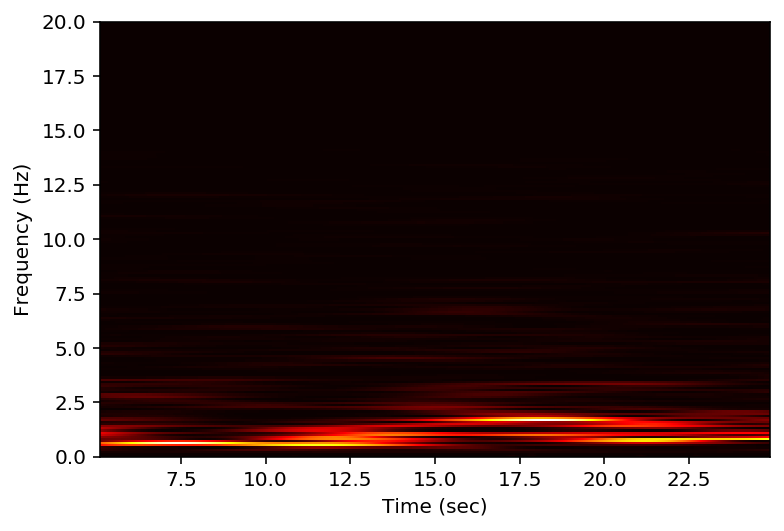

In [24]:
window_size = 1024; # Define the number of elements in our binning window
wind = np.hanning(window_size) # Create a "hanning" window with our given size

# Create the spectrogram and plot

fig = plt.figure() 
f, tt, Sxx = signal.spectrogram(data,sampling_freq,wind,len(wind),len(wind)-1)
plt.pcolormesh(tt,f,Sxx,cmap='hot') #14
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.ylim([0,20])
plt.show()

This isn't particularly interesting -- it's 30 seconds of someone sleeping, after all! But you can clearly see some power in the delta band.

The goal of many labs on campus (and in neuroscience) is to understand the physiological mechanism behind these wavelengths and the shape of the brain's PSD. For example, what factors are correlated with the shapes of the peaks? What are the physiological bases of these peaks?

## About this notebook

Some of the code in this notebook was adapted from [this tutorial](https://raphaelvallat.com/bandpower.html) by Raphael Vallat, [these tutorials](https://github.com/voytekresearch/Tutorials) from Torben Noto, and _Neural Data Science_ by Pascal Wallisch.